<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Color_Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [51]:
import os
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')
y_idx = pd.read_csv('idx_y.csv')

Remove elements from y that were not RBG but grayscale by index

In [6]:
y = y[0:10001]

In [7]:
y_ = np.delete(y,y_idx.iloc[:,1],axis=0)

In [8]:
y_.shape

(9976, 3)

NEW APPROACH:

Fit CNN on orginal images, so no salience maps

1. Read `n-rows`from X.

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [10]:
X = np.load('mscoco_og.npy')

In [11]:
X = np.swapaxes(X,0,3)

In [12]:
X = np.swapaxes(X,1,3)

In [13]:
X.shape

(9976, 3, 224, 224)

In [14]:
X_ = torch.from_numpy(X).to(device)

In [15]:
y_ = torch.from_numpy(y_).to(device)

In [16]:
del X
gc.collect()

23

Converting X to appropriate Datatype...

In [17]:
X_ = torch.tensor(X_,dtype = torch.float32)

y_ = y_.type(torch.LongTensor)

<ipython-input-17-e30e4ab0470a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_ = torch.tensor(X_,dtype = torch.float32)


In [24]:
X_[0,:,:,:].shape

torch.Size([3, 224, 224])

In [42]:
Mean_color_R = []
Mean_color_G = []
Mean_color_B = []

for idx, img in enumerate(X_):
  R_mean, G_mean ,B_mean = X_[idx,:,:,:].mean(dim = [1,2]).to('cpu')
  Mean_color_R.append(R_mean)
  Mean_color_G.append(G_mean)
  Mean_color_B.append(B_mean)



In [44]:
Color_Array = np.array((Mean_color_R, Mean_color_G, Mean_color_B), dtype=float)

In [46]:
Color_Array.shape

(3, 9976)

To get max value of classN-1

In [47]:
y_ = y_-1

In [57]:
y_.to('cpu');
y_ = y_.numpy();

In [82]:
Color_Array=np.reshape(Color_Array,(9976,3))

In [83]:
X_train,X_test,y_train,y_test = train_test_split(Color_Array,y_,test_size=0.3,random_state=42)

In [63]:
Color_Array.shape,y_.shape

((3, 9976), (9976, 3))

In [66]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6983, 3), (2993, 3), (6983, 3), (2993, 3))

In [84]:
np.mean(X_train),np.mean(X_test), np.std(X_train),np.std(X_test)

(0.43370424509169386,
 0.43340951945997386,
 0.13018049668223647,
 0.13041735048829012)

In [74]:
from sklearn.preprocessing import StandardScaler

In [76]:
Scaler = StandardScaler()

In [85]:
X_train = Scaler.fit_transform(X_train)

In [86]:
X_test = Scaler.transform(X_test)

In [87]:
np.mean(X_train),np.mean(X_test), np.std(X_train),np.std(X_test)

(-3.29002078231561e-17,
 -0.0022130054273679913,
 1.0000000000000009,
 1.00209554867872)

In [91]:
X_tensor_train = torch.from_numpy(X_train)
X_tensor_test = torch.from_numpy(X_test)

y_tensor_train = torch.from_numpy(y_train)
y_tensor_test = torch.from_numpy(y_test)

In [92]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)

<ipython-input-92-ace8a0b3a68e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-92-ace8a0b3a68e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


In [93]:
torch.mean(X_tensor_train),torch.mean(X_tensor_test),torch.std(X_tensor_train),torch.std(X_tensor_test)

(tensor(3.6419e-10), tensor(-0.0022), tensor(1.0000), tensor(1.0022))

Setup custom dataset class

In [96]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):#,transform=None):
        self.X = X
        self.y = y
        #self.transform = transforms.Compose([X.to])
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        #if self.transform:
         # X = self.transform(X)
 
        return X, y

In [97]:
train_dataset = SimpleDataset(X_tensor_train,y_tensor_train)#,transform=True)

In [98]:
test_dataset = SimpleDataset(X_tensor_test,y_tensor_test)

In [124]:
dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=False) 
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True) 

In [ ]:
for x,y in dataloader_train:
  print(x.shape)

In [123]:
X_tensor_train.shape

torch.Size([6983, 3])

Setting up the Classification DNN

In [147]:
import torch.nn.functional as F

class Dnn(nn.Module):
    def __init__(self,n_inputs,n_hidden,n_hidden_2):
        super().__init__()
        self.in_layer = nn.Linear(n_inputs,n_hidden)
        self.dropout = nn.Dropout(0.25)
        self.hid_layer = nn.Linear(n_hidden, n_hidden_2)
        self.Arousal = nn.Linear(n_hidden_2,10)
        self.Valence = nn.Linear(n_hidden_2,10)
        self.Dominance = nn.Linear(n_hidden_2,10)

        
    def forward(self, x):
        x = torch.relu(self.in_layer(x))
        x = self.dropout(x)
        X = self.hid_layer(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance 
#removed 

In [102]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [148]:
ColorNet = Dnn(3,2,2)
ColorNet.to(device)

Dnn(
  (in_layer): Linear(in_features=3, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (hid_layer): Linear(in_features=2, out_features=2, bias=True)
  (Arousal): Linear(in_features=2, out_features=10, bias=True)
  (Valence): Linear(in_features=2, out_features=10, bias=True)
  (Dominance): Linear(in_features=2, out_features=10, bias=True)
)

In [114]:
criterion = nn.CrossEntropyLoss()

In [115]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,dataloader_val,
          epoch=100, learning_rate=0.0001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_epoch_loss = []
    val_epoch_loss = []
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)
        val_loop = tqdm(dataloader_val)
        total = 0
        correct_a,correct_v,correct_d=0,0,0
        net.to(device)   
        net.train()
        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())

            _a, y_pred_train_arousal = torch.max(Arousal,1)
            _v, y_pred_train_valence = torch.max(Valence,1)
            _d, y_pred_train_dominance = torch.max(Dominance,1)

            total += label[:,0].size(0)+label[:,1].size(0)+label[:,2].size(0)

            correct_a += (y_pred_train_arousal == label[:,0]).sum().item()
            correct_v += (y_pred_train_valence == label[:,1]).sum().item()
            correct_d += (y_pred_train_dominance == label[:,2]).sum().item()
           
            sum_correct = (correct_a+correct_v+correct_d)
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance

      
            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update
            
            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")

        train_accuracy.append(sum_correct/total)
        train_epoch_loss.append((np.array(train_loss).mean()))

        #validation
        net.eval()
        val_total = 0
        val_arousal,val_valence, val_dominance = 0,0,0
        for data, labels in dataloader_val:
            data, labels = data.to(device), labels.to(device)

            Arousal_v,Valence_v,Dominance_v = net(data.float())

            _a, y_pred_val_arousal = torch.max(Arousal_v,1)
            _v, y_pred_val_valence = torch.max(Valence_v,1)
            _d, y_pred_val_dominance = torch.max(Dominance_v,1)

            val_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

            val_arousal += (y_pred_val_arousal == labels[:,0]).sum().item()
            val_valence += (y_pred_val_valence == labels[:,1]).sum().item()
            val_dominance += (y_pred_val_dominance == labels[:,2]).sum().item()
           
            sum_correct_val = (val_arousal+val_valence+val_dominance)
          
            loss_arousal_v = loss_fn(Arousal_v,labels[:,0])
            loss_valence_v = loss_fn(Valence_v,labels[:,1])
            loss_dominance_v = loss_fn(Dominance_v,labels[:,2])

            val_l=loss_arousal_v+loss_valence_v+loss_dominance_v
        
            val_loss.append(val_l.item())

        val_epoch_loss.append((np.array(val_loss).mean()))

        val_accuracy.append(sum_correct_val/val_total)


    return train_loss,train_epoch_loss,val_loss,val_epoch_loss, train_accuracy,val_accuracy


In [116]:
def test(net,loss_fn,dataloader_test):
  net.eval()
  test_loss = []
  test_total,test_correct = 0,0
  test_acc = []
  test_loop = tqdm(dataloader_test)
  i=0
  for batch, (data, labels) in enumerate(test_loop):
      print('testing...')

      data, labels = data.to(device), labels.to(device)
      arousal,valence,dominance = net(data.float())

      arousal_t = loss_fn(arousal,labels[:,0])
      valence_t = loss_fn(valence,labels[:,1])
      dominance_t = loss_fn(dominance,labels[:,2])

      test_l = arousal_t+valence_t+dominance_t

      test_loss.append(test_l.item())
      test_loop.set_description(f"Batch [{i+1}/{batch}]")
      i=+1

        #test_total += labels.size(0)
        #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    #test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc)
  return test_loss

In [117]:
import matplotlib.pyplot as plt

In [118]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [136]:
X_tensor_train.shape[1]

3

In [155]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,val_loss,val_epoch_loss,train_acc,val_acc=train(net=ColorNet,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_val=dataloader_test,epoch=200)




  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?

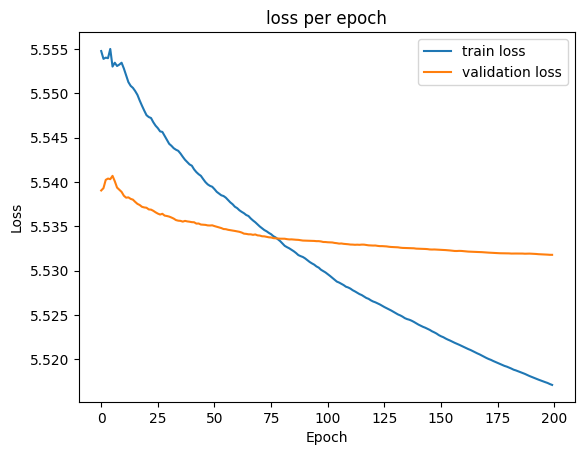

In [156]:
plt.plot(train_epoch_loss, label = 'train loss')
plt.plot(val_epoch_loss, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss per epoch')
plt.legend()
plt.show()

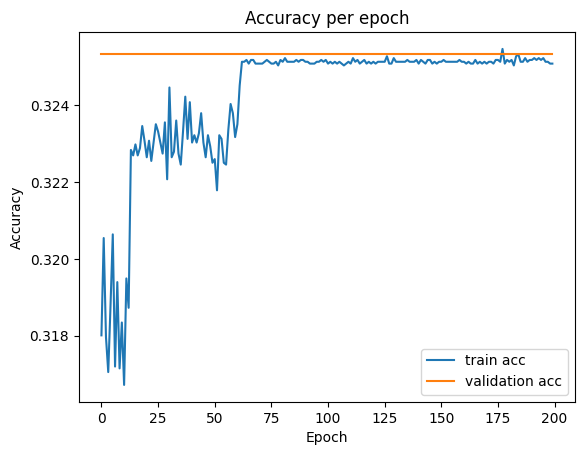

In [157]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

In [ ]:
test_loss = test(net=SalienceNet,loss_fn=criterion,dataloader_test=dataloader_test)

In [ ]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Loss')
plt.title('Loss for test data')
plt.show()